# 1 - Imports

In [2]:
import os
import numpy as np
import tensorflow as tf
import glob
from tqdm import tqdm
import pickle
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# 2- Dataset

## 2.1- Obter o Dataset

In [3]:
# url do dataset
dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"

# download do dataset
data_dir = tf.keras.utils.get_file(
    fname="images",
    origin=dataset_url,
    untar=True
)

In [4]:
# path das imagens
data_dir = os.path.join(os.path.dirname(data_dir), 'images')

## 2.2 - Análise do Dataset

In [5]:
# nomes de cada imanges
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(data_dir, '*.jpg'))]

In [6]:
# numero de imagens
len(imageNames)

7390

In [7]:
# calculo do numero de classes
labels = [' '.join(name.split('_')[:-1]) for name in imageNames ]

print(f"\nNúmero total de classes : {len(np.unique(labels))}")


Número total de classes : 37


In [9]:
# dicionario para cada classe
labelDicionary = {name : ind for ind, name in enumerate(np.unique(labels))}
for k, v in labelDicionary.items():
    print(f"{k:32} : {v}")

Abyssinian                       : 0
Bengal                           : 1
Birman                           : 2
Bombay                           : 3
British Shorthair                : 4
Egyptian Mau                     : 5
Maine Coon                       : 6
Persian                          : 7
Ragdoll                          : 8
Russian Blue                     : 9
Siamese                          : 10
Sphynx                           : 11
american bulldog                 : 12
american pit bull terrier        : 13
basset hound                     : 14
beagle                           : 15
boxer                            : 16
chihuahua                        : 17
english cocker spaniel           : 18
english setter                   : 19
german shorthaired               : 20
great pyrenees                   : 21
havanese                         : 22
japanese chin                    : 23
keeshond                         : 24
leonberger                       : 25
miniature pinscher    

## 2.3 - Carregar ficheiro com as labels e classes de cada imagem 

In [10]:
with open('Oxford-IIIT-Pet_Dics.p', 'rb') as file:
    dataLabels = pickle.load(file)

In [11]:
dataLabels

{'classDic': {'american_bulldog': 0,
  'american_pit_bull_terrier': 1,
  'basset_hound': 2,
  'beagle': 3,
  'boxer': 4,
  'chihuahua': 5,
  'english_cocker_spaniel': 6,
  'english_setter': 7,
  'german_shorthaired': 8,
  'great_pyrenees': 9,
  'havanese': 10,
  'japanese_chin': 11,
  'keeshond': 12,
  'leonberger': 13,
  'miniature_pinscher': 14,
  'newfoundland': 15,
  'pomeranian': 16,
  'pug': 17,
  'saint_bernard': 18,
  'samoyed': 19,
  'scottish_terrier': 20,
  'shiba_inu': 21,
  'staffordshire_bull_terrier': 22,
  'wheaten_terrier': 23,
  'yorkshire_terrier': 24,
  'Abyssinian': 25,
  'Bengal': 26,
  'Birman': 27,
  'Bombay': 28,
  'British_Shorthair': 29,
  'Egyptian_Mau': 30,
  'Maine_Coon': 31,
  'Persian': 32,
  'Ragdoll': 33,
  'Russian_Blue': 34,
  'Siamese': 35,
  'Sphynx': 36},
 'filesDic': {'Abyssinian_1.jpg': {'species': 'cat',
   'breed': 'Abyssinian',
   'target': 25,
   'imgDim': (400, 600, 3),
   'bndBox': [333, 72, 92, 86],
   'foldTrain': True},
  'Abyssinian_10

## 2.4 - Divisão binaria dos dados e de treino e teste do ficheiro "Oxford-IIIT-Pet_Dics.p"

In [12]:
# vars para guardar o mome dos ficheiros na respetiva classe e divisão de treino ou teste
train_cats = []
train_dogs = []
test_cats = []
test_dogs = []

# procura no dicionario a e especie de cada foto e a que fold pertece 
for file_name, file_data in dataLabels['filesDic'].items():
    if file_data['species'] == 'cat':
        if file_data['foldTrain']:
            train_cats.append(file_name) # adicona o nome à lista train_cats
        else:
            test_cats.append(file_name) # adicona o nome à lista test_cats
    elif file_data['species'] == 'dog':
        if file_data['foldTrain']:
            train_dogs.append(file_name) # adicona o nome à lista train_dogs
        else:
            test_dogs.append(file_name) # adicona o nome à lista test_dogs

In [13]:
# var para guardar as fotos num np.array
imageData = []

# tamanho das imagens
IMAGE_SIZE = (128, 128)

# carrega as imagens da diretoria data_dir para o array imageData e faz o resize para a dimenção 128x128
for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(data_dir, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData.shape

Loading image data: 100%|████████████████████████████████████████████████████| 7390/7390 [00:37<00:00, 198.32 images/s]


(7390, 128, 128, 3)

In [14]:
# procura os nome presentes nas listas de gatos e caes de treino e teste na file principal e qual o seu id 
cat_train_indices = []
for i1, filename1 in enumerate(os.listdir(data_dir)): # corre os indices e os nomes no ficheiro
    if filename1 in train_cats: # se econtrar o nome na lista de gatos para treino vai então adicionar o indice
        cat_train_indices.append(i1) # adiciona o id á lista
        
dog_train_indices = []
for i2, filename2 in enumerate(os.listdir(data_dir)): # corre os indices e os nomes no ficheiro
    if filename2 in train_dogs: # se econtrar o nome na lista de caes para treino vai então adicionar o indice
        dog_train_indices.append(i2) # adiciona o id á lista
         
cat_test_indices = []
for i3, filename3 in enumerate(os.listdir(data_dir)): # corre os indices e os nomes no ficheiro
    if filename3 in test_cats: # se econtrar o nome na lista de gatos para teste vai então adicionar o indice
        cat_test_indices.append(i3) # adiciona o id á lista
        
dog_test_indices = []
for i4, filename4 in enumerate(os.listdir(data_dir)): # corre os indices e os nomes no ficheiro
    if filename4 in test_dogs: # se econtrar o nome na lista de caes para teste vai então adicionar o indice
        dog_test_indices.append(i4) # adiciona o id á lista

In [15]:
# cria os arrays das imagens com os indices corerspondentes do array de todas as imagens
cat_train_images = imageData[cat_train_indices]
dog_train_images = imageData[dog_train_indices]
cat_test_images = imageData[cat_test_indices]
dog_test_images = imageData[dog_test_indices]

## 2.5 - Criação das labels para treino e teste
### 0 - Gato / 1 - Cão

In [17]:
# criar as labels para os dados de treino
train_labels = [0] * len(cat_train_images) + [1] * len(dog_train_images)

# concatenar as duas classes
train_data_cats_dogs = np.concatenate((cat_train_images, dog_train_images))

# criar as labels para os dados de teste
test_labels = [0] * len(cat_test_images) + [1] * len(dog_test_images)

# concatenar as duas classes
test_data_cats_dogs = np.concatenate((cat_test_images, dog_test_images))

# 2.6 - Preparar e misturar os dados para treino e teste

In [18]:
# indices aleatorios
indices = np.random.permutation(len(train_data_cats_dogs))

# converter as labels para array
train_labels_array = np.array(train_labels)

# misturar os arrays com os indices aleatorios
shuffled_train_data_cats_dogs = train_data_cats_dogs[indices]
shuffled_train_labels = train_labels_array[indices]

# indices aleatorios
indices2 = np.random.permutation(len(test_data_cats_dogs))

# converter as labels para array
test_labels_array = np.array(test_labels)

# misturar os arrays com os indices aleatorios
shuffled_test_data_cats_dogs = test_data_cats_dogs[indices]
shuffled_test_labels = test_labels_array[indices]

## 2.7 - Verificação de aleatoridade

In [19]:
# classe da fotografia de indice 1168 de teste
shuffled_test_labels[1168]

0

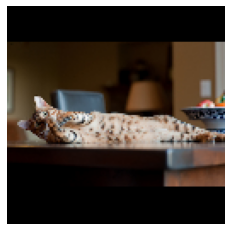

In [20]:
# verificação visual se a fotografia de indice 1168 de teste é um gato
plt.imshow(shuffled_test_data_cats_dogs[1168])
plt.axis('off')  # Hide axes
plt.show()

In [21]:
# converter os arrays para um dataset do TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((shuffled_train_data_cats_dogs, shuffled_train_labels))
train_dataset = (
    train_dataset.batch(32)
    .prefetch(1)
)

test_dataset = tf.data.Dataset.from_tensor_slices((shuffled_test_data_cats_dogs, shuffled_test_labels))
test_dataset = (
    test_dataset.batch(32)
    .prefetch(1)
)

In [22]:
train_data_cats_dogs.shape

(3686, 128, 128, 3)

# 3 - Modelo de classificação binária sem data augumentation

In [199]:
model = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 3.1 - Treino do modelo 

In [203]:
history1 = model.fit(train_dataset, epochs=30)

Epoch 1/30
116/116 [==============================] - 42s 363ms/step - loss: 0.3780 - accuracy: 0.8209
Epoch 2/30
116/116 [==============================] - 42s 365ms/step - loss: 0.3420 - accuracy: 0.8473
Epoch 3/30
116/116 [==============================] - 42s 362ms/step - loss: 0.3285 - accuracy: 0.8397
Epoch 4/30
116/116 [==============================] - 42s 363ms/step - loss: 0.3119 - accuracy: 0.8527
Epoch 5/30
116/116 [==============================] - 43s 371ms/step - loss: 0.2796 - accuracy: 0.8755
Epoch 6/30
116/116 [==============================] - 43s 367ms/step - loss: 0.2548 - accuracy: 0.8801
Epoch 7/30
116/116 [==============================] - 43s 368ms/step - loss: 0.2261 - accuracy: 0.9042
Epoch 8/30
116/116 [==============================] - 42s 364ms/step - loss: 0.1970 - accuracy: 0.9061
Epoch 9/30
116/116 [==============================] - 42s 363ms/step - loss: 0.1527 - accuracy: 0.9295
Epoch 10/30
116/116 [==============================] - 43s 368ms/step - l

## 3.2 -  Resultados do modelo de classificação binaria sem data augumentation

In [207]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

116/116 [==============================] - 8s 71ms/step - loss: 4.8196 - accuracy: 0.6327
Test Loss: 4.8196
Test Accuracy: 0.6327


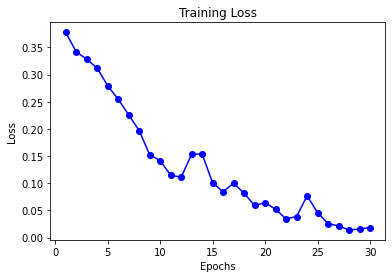

In [206]:
loss = history1.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 4 - Modelo de classificação binaria com data augumentation 

## 4.1 - Data augmentation

In [122]:
# data augmentation
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')

# data augmentation dos dados de treino
train_data = train_gen.flow(x = shuffled_train_data_cats_dogs, y = shuffled_train_labels, batch_size = 32, shuffle = True)
len(train_data)

116

In [24]:
# data augmentation dos dados de teste
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = shuffled_test_data_cats_dogs, y = shuffled_test_labels, batch_size = 32)
len(test_data)

116

## 4.2 - Criação do modelo 

In [236]:
model2 = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# compilar o modelo
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 4.3 - Treino do modelo 

In [237]:
history2 = model2.fit(train_data, epochs=30)

Epoch 1/30
116/116 [==============================] - 47s 404ms/step - loss: 0.6372 - accuracy: 0.6655
Epoch 2/30
116/116 [==============================] - 47s 401ms/step - loss: 0.5987 - accuracy: 0.6788
Epoch 3/30
116/116 [==============================] - 46s 398ms/step - loss: 0.5964 - accuracy: 0.6769
Epoch 4/30
116/116 [==============================] - 46s 396ms/step - loss: 0.5690 - accuracy: 0.6972
Epoch 5/30
116/116 [==============================] - 46s 393ms/step - loss: 0.5616 - accuracy: 0.7043
Epoch 6/30
116/116 [==============================] - 45s 391ms/step - loss: 0.5597 - accuracy: 0.7122
Epoch 7/30
116/116 [==============================] - 48s 414ms/step - loss: 0.5473 - accuracy: 0.7132
Epoch 8/30
116/116 [==============================] - 45s 390ms/step - loss: 0.5275 - accuracy: 0.7363
Epoch 9/30
116/116 [==============================] - 46s 393ms/step - loss: 0.5288 - accuracy: 0.7325
Epoch 10/30
116/116 [==============================] - 46s 400ms/step - l

## 4.4 - Resultados do modelo de classificação binaria com data augumentation 

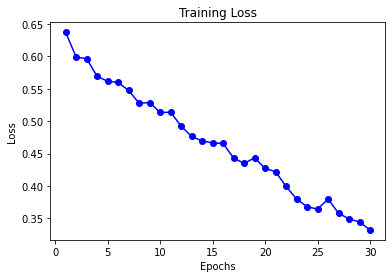

In [238]:
loss = history2.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [239]:
loss, accuracy = model2.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

116/116 [==============================] - 9s 76ms/step - loss: 0.3734 - accuracy: 0.8432
Test Loss: 0.3734
Test Accuracy: 0.8432


# 5 - Modelo de classificação Multi-classe 

## 5.1 - Formatação dos dados para treino multi-classe 

In [74]:
# lsitas para as imagens e as labels
images = []
labels = []

# resolução das imagens
IMAGE_SIZE = (224, 224)

# percorre a lista de imagens, faz o resize de cada imagem e adiciona-a à lista das imagens, verifica o nome da imagem e adiciona a parte pretentida à lista das labels
for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(data_dir, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    images.append(img) 
    name_parts = name.split("_")[0:-1] # separa o nome da imagem pelos "_" e a parte não numerica
    name = "_".join(name_parts) # junta as strings com um "_"
    labels.append(name) # adiciona a nova string à lista das lables
    
# converte as listas em arrays do numpy
images = np.array(images)
labels = np.array(labels)

Loading image data: 100%|████████████████████████████████████████████████████| 7390/7390 [00:43<00:00, 168.73 images/s]


## 5.2 - Verificações do ponto 5.1 

In [75]:
images.shape

(7390, 224, 224, 3)

In [76]:
labels.shape

(7390,)

In [77]:
labels[233]

'american_bulldog'

## 5.3 - Coverter as stings das labels para numeros inteiros 

In [78]:
# label encoder
label_encoder = LabelEncoder()

# transformar o array das labels de string em numero inteiro
labels_dici = label_encoder.fit_transform(labels)

In [79]:
labels_dici.shape

(7390,)

In [80]:
labels_dici[7389]

36

## 5.4 - Misturar os dados 

In [81]:
# indices aleatorios
indices_multi = np.random.permutation(len(images))

# misturar os arrays com os indices aleatorios
shuffled_images = images[indices_multi]
shuffled_labels = labels_dici[indices_multi]

In [82]:
len(shuffled_images)

7390

## 5.5 - Verificação visual do ponto 5.4

In [83]:
# classe da imagem de indice 137
shuffled_labels[137]

2

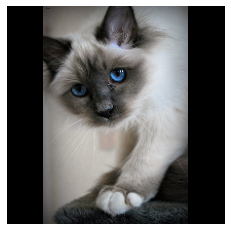

In [84]:
# display da imagem de indice 137 para comparar com a classe 2 
plt.imshow(shuffled_images[137])
plt.axis('off')  # Hide axes
plt.show()

## 5.6 - Split em treino e teste

In [85]:
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.2, random_state=42)

In [86]:
test_labels.shape

(1478,)

In [110]:
# vars de treino
x_train = train_images
y_train = train_labels

# vars de teste
x_test = test_images
y_test = test_labels

# normalizar os dados para valores entre 0 e 1 
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# coverter as labels para one-hot encoded vectors
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

In [111]:
# split de validação
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 6 - Modelo de classificação multi-classe sem data augumentation 

In [329]:
model3 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(37, activation='softmax')
])

model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## 6.1 - Treino do modelo

In [330]:
history3 = model3.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
148/148 [==============================] - 61s 406ms/step - loss: 3.6020 - accuracy: 0.0368 - val_loss: 3.5174 - val_accuracy: 0.0558
Epoch 2/10
148/148 [==============================] - 57s 387ms/step - loss: 3.3092 - accuracy: 0.0992 - val_loss: 3.1386 - val_accuracy: 0.1471
Epoch 3/10
148/148 [==============================] - 61s 409ms/step - loss: 2.8716 - accuracy: 0.2087 - val_loss: 3.0873 - val_accuracy: 0.1530
Epoch 4/10
148/148 [==============================] - 58s 394ms/step - loss: 2.3923 - accuracy: 0.3235 - val_loss: 3.0052 - val_accuracy: 0.1978
Epoch 5/10
148/148 [==============================] - 59s 399ms/step - loss: 1.6529 - accuracy: 0.5251 - val_loss: 3.4871 - val_accuracy: 0.2088
Epoch 6/10
148/148 [==============================] - 60s 407ms/step - loss: 0.8749 - accuracy: 0.7460 - val_loss: 4.2622 - val_accuracy: 0.1986
Epoch 7/10
148/148 [==============================] - 65s 440ms/step - loss: 0.3539 - accuracy: 0.9023 - val_loss: 5.5353 - val_ac

## 6.2 - Resultados do modelo de classificação multi-classe sem data augumentation 

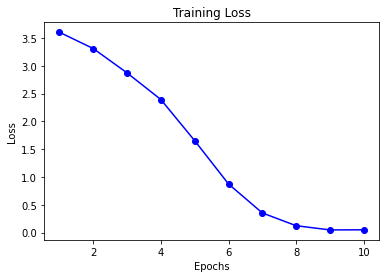

In [331]:
loss = history3.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [333]:
test_loss, test_acc = model3.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

47/47 [==============================] - 3s 70ms/step - loss: 7.2673 - accuracy: 0.1644
Test Loss: 7.267346382141113
Test Accuracy: 0.16441136598587036


# 7 - Modelo de classificação multi-classe com data augmentation

## 7.1 - Data augmentation

In [42]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True 
)

## 7.2 - Criação do modelo  de classificação multi-classe com data augmentation

In [412]:
model4 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(37, activation='softmax')
])

model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [413]:
# treino do modelo com data augmentation
history4 = model4.fit(datagen.flow(x_train, y_train, batch_size=32),steps_per_epoch=len(x_train) // 32,epochs=10,validation_data=(x_val, y_val))

Epoch 1/10
147/147 [==============================] - 66s 447ms/step - loss: 3.6107 - accuracy: 0.0336 - val_loss: 3.5947 - val_accuracy: 0.0524
Epoch 2/10
147/147 [==============================] - 66s 450ms/step - loss: 3.4593 - accuracy: 0.0732 - val_loss: 3.3284 - val_accuracy: 0.0811
Epoch 3/10
147/147 [==============================] - 66s 450ms/step - loss: 3.2330 - accuracy: 0.1177 - val_loss: 3.3129 - val_accuracy: 0.0964
Epoch 4/10
147/147 [==============================] - 70s 478ms/step - loss: 3.0990 - accuracy: 0.1414 - val_loss: 3.0775 - val_accuracy: 0.1547
Epoch 5/10
147/147 [==============================] - 67s 452ms/step - loss: 3.0234 - accuracy: 0.1590 - val_loss: 2.9922 - val_accuracy: 0.1902
Epoch 6/10
147/147 [==============================] - 66s 452ms/step - loss: 2.9275 - accuracy: 0.1822 - val_loss: 2.9865 - val_accuracy: 0.1860
Epoch 7/10
147/147 [==============================] - 70s 476ms/step - loss: 2.8534 - accuracy: 0.2080 - val_loss: 2.8546 - val_ac

## 7.3 - Resultados do modelo de classificação multi-classe com data augumentation 

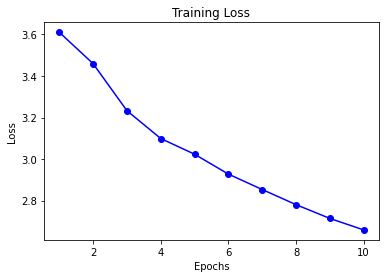

In [414]:
loss = history4.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [416]:
test_loss, test_acc = model4.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

47/47 [==============================] - 4s 77ms/step - loss: 2.7744 - accuracy: 0.2490
Test Loss: 2.774411678314209
Test Accuracy: 0.24898511171340942


# 8 - Modelo pre-treinado para classificação multi-classe 

In [112]:
# modelo pre-treinado VGG16 
modeloVGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [113]:
# poribir o modelo de treinar
for layer in modeloVGG16.layers:
    layer.trainable = False

In [114]:
# adição de camadas para a classificação das 37 classes
modeloPre = Sequential()
modeloPre.add(modeloVGG16)
modeloPre.add(Flatten())
modeloPre.add(Dense(256, activation='relu'))
modeloPre.add(Dense(37, activation='softmax'))

# compilar o modelo
modeloPre.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 8.1 Treino do modelo para classificar as 37 classes

In [115]:
modeloPre.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
148/148 [==============================] - 666s 5s/step - loss: 3.1127 - accuracy: 0.1804 - val_loss: 2.3026 - val_accuracy: 0.3119
Epoch 2/10
148/148 [==============================] - 694s 5s/step - loss: 1.6211 - accuracy: 0.5454 - val_loss: 1.7617 - val_accuracy: 0.4708
Epoch 3/10
148/148 [==============================] - 673s 5s/step - loss: 0.9614 - accuracy: 0.7450 - val_loss: 1.6325 - val_accuracy: 0.5080
Epoch 4/10
148/148 [==============================] - 690s 5s/step - loss: 0.6146 - accuracy: 0.8562 - val_loss: 1.6146 - val_accuracy: 0.5207
Epoch 5/10
148/148 [==============================] - 667s 5s/step - loss: 0.3666 - accuracy: 0.9328 - val_loss: 1.5849 - val_accuracy: 0.5368
Epoch 6/10
148/148 [==============================] - 703s 5s/step - loss: 0.2248 - accuracy: 0.9712 - val_loss: 1.4616 - val_accuracy: 0.5571
Epoch 7/10
148/148 [==============================] - 716s 5s/step - loss: 0.1314 - accuracy: 0.9922 - val_loss: 1.4434 - val_accuracy: 0.5714

## 8.2 - Resultados do modelo pre-treinado 

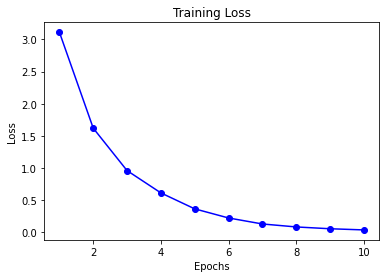

In [117]:
loss = [3.1127,1.6211,0.9614,0.6146,0.3666,0.2248,0.1314,0.0852,0.0571,0.0389]
epochs = [1,2,3,4,5,6,7,8,9,10]

plt.plot(epochs, loss, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [116]:
test_loss, test_acc = modeloPre.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

47/47 [==============================] - 165s 4s/step - loss: 1.4356 - accuracy: 0.5771
Test Loss: 1.4355677366256714
Test Accuracy: 0.5771312713623047


# 9 - Comparações de resultados

### Modelo de classificação binária:

    Sem data augmentation:
        Test Loss: 4.8196
        Test Accuracy: 0.6327
    Com data augmentation:
        Test Loss: 0.3734
        Test Accuracy: 0.8432
        
     Para a classificação binária, foram treinados dois modelos para os quais a diferenca foram apenas os dados fornecidos para treino. Pois para um deles, foi efetuada uma data augmentation, tendo melhorado significativamente o desempenho do mesmo, desempenho esse que poderia melhorar ainda mais tendo em conta o gráfico da evolução do loss do modelo que apresneta um declive final superior ao do gráfico de evolução do loss do modelo sem data augmentation.
    
### Modelo de classificação multi-classe:

    Sem data augmentation:
        Test Loss: 7.267346382141113
        Test Accuracy: 0.16441136598587036
    Com data augmentation:
        Test Loss: 2.774411678314209
        Test Accuracy: 0.24898511171340942
    
    Para os modelos de classificação multi-classe verificou-se que o desempenho ficou longe de um bom resultado. Pois para o modelo sem data augmentation a arquitetura escolhida pode não ter sido o melhor já que os resuldados com o dataset de treino, divergiram bastante dos resultados com os dados de teste, o que apresenta claramente um caso de overfitting. Já para o modelo onde foi efetuada a data augmentation dos dados de treino, não ocorreu overfitting mas  os resultados não melhoraram significativamente, no entanto, constatámos pelo gráfico de evolução do loss do modelo, que estes poderiam melhorar com um maior tempo de treino do modelo, que não foi possivel, devido á falta de recursos computacionais.
    
### Modelo pré treinado:
       Com data augmentation:
           Test Loss: 1.4355677366256714
           Test Accuracy: 0.5771312713623047
           
    Já para o modelo pré-preinado, foi utilizado o modelo VGG16 do keras e foram adicionadas as camadas necessarias para a classificação das 37 classes. Os resultados deste modelo, foram ao encontro do esperado, já que em comparação com o nosso modelo com data augmentation a precisão aumentou para mais do dobro. O que faz sentido já que este modelo é projetado para lidar com imagens e já treinou com um vasto conjunto de dados.